In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Stephen/Case Study 2/datasets/web_log_data.csv', na_filter=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5866 entries, 0 to 5865
Data columns (total 6 columns):
ip           5866 non-null object
date_time    5866 non-null object
request      5866 non-null object
step         5866 non-null int64
session      5866 non-null int64
user_id      5866 non-null int64
dtypes: int64(3), object(3)
memory usage: 275.0+ KB


In [3]:
print(df['request'].value_counts())

/                                                                821
/favicon.ico                                                     554
/robots.txt                                                      395
/eaglefarm/javascript/menu.js                                    370
/eaglefarm/pdf/Web_Price_List.pdf                                296
/eaglefarm/                                                      286
/services.html                                                   244
/eaglefarm/pricelist/                                            189
/eaglefarm/pricelist                                             187
/more.html                                                       145
/direct.html                                                     107
/eaglefarm/specials/                                             103
/eaglefarm/contact                                                95
/eaglefarm/contact/                                               93
/eaglefarm                        

In [19]:
df['date_time'] = pd.to_datetime(df['date_time'], format="%d/%b/%Y:%H:%M:%S")  # set date time to pandas datatime obj

df['Day'] = df['date_time'].dt.day
df['Month'] = df['date_time'].dt.month
df['Hour'] = df['date_time'].dt.hour
df['Day_of_week'] = df['date_time'].dt.dayofweek
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5866 entries, 0 to 5865
Data columns (total 10 columns):
ip             5866 non-null object
date_time      5866 non-null datetime64[ns]
request        5866 non-null object
step           5866 non-null int64
session        5866 non-null int64
user_id        5866 non-null int64
Day            5866 non-null int64
Month          5866 non-null int64
Hour           5866 non-null int64
Day_of_week    5866 non-null int64
dtypes: datetime64[ns](1), int64(7), object(2)
memory usage: 458.4+ KB


In [22]:
df['request'] = df['request'].str.rstrip('\/')
df.replace(r'^\s*$', 'homepage', regex=True, inplace = True)
print(df['request'].value_counts())

homepage                                                         821
/favicon.ico                                                     554
/robots.txt                                                      395
/eaglefarm                                                       378
/eaglefarm/pricelist                                             376
/eaglefarm/javascript/menu.js                                    370
/eaglefarm/pdf/Web_Price_List.pdf                                296
/services.html                                                   244
/eaglefarm/contact                                               188
/eaglefarm/specials                                              174
/richlands                                                       169
/more.html                                                       145
/richlands/contact                                               126
/direct.html                                                     107
/eaglefarm/fileupload             

In [24]:
requestsByUser = df.groupby(['user_id'])['request'].apply(list)
print(requestsByUser.head(5))

user_id
1                                        [/robots.txt]
2                        [/code/Global/code/menu.html]
3    [homepage, /favicon.ico, /guarantee.html, /mor...
4                                        [/robots.txt]
5                           [/code/Ultra/services.htm]
Name: request, dtype: object


In [25]:
from apyori import apriori

# type cast the transactions from pandas into normal list format and run apriori
requestsByUser_list = list(requestsByUser)
results = list(apriori(requestsByUser_list, min_support=0.1))


def convert_apriori_results_to_pandas_df(results):
    rules = []

    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                          rule_set.support, rule.confidence, rule.lift])

            # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift'])


result_df = convert_apriori_results_to_pandas_df(results)
print(result_df.head(20))

                       Left_side                     Right_side   Support  \
0                                                    /eaglefarm  0.135637   
1                                 /eaglefarm/javascript/menu.js  0.143373   
2                                                  /favicon.ico  0.109335   
3                                                   /robots.txt  0.202166   
4                                                /services.html  0.120165   
5                                                      homepage  0.373904   
6                     /eaglefarm  /eaglefarm/javascript/menu.js  0.112429   
7  /eaglefarm/javascript/menu.js                     /eaglefarm  0.112429   
8                 /services.html                       homepage  0.100567   
9                       homepage                 /services.html  0.100567   

   Confidence      Lift  
0    0.135637  1.000000  
1    0.143373  1.000000  
2    0.109335  1.000000  
3    0.202166  1.000000  
4    0.120165  1.00000

In [26]:
# sort all acquired rules descending by lift

result_df = result_df.sort_values(by='Confidence', ascending=False)
print(result_df.head(10))

                       Left_side                     Right_side   Support  \
8                 /services.html                       homepage  0.100567   
6                     /eaglefarm  /eaglefarm/javascript/menu.js  0.112429   
7  /eaglefarm/javascript/menu.js                     /eaglefarm  0.112429   
5                                                      homepage  0.373904   
9                       homepage                 /services.html  0.100567   
3                                                   /robots.txt  0.202166   
1                                 /eaglefarm/javascript/menu.js  0.143373   
0                                                    /eaglefarm  0.135637   
4                                                /services.html  0.120165   
2                                                  /favicon.ico  0.109335   

   Confidence      Lift  
8    0.836910  2.238301  
6    0.828897  5.781410  
7    0.784173  5.781410  
5    0.373904  1.000000  
9    0.268966  2.23830

In [27]:
DailySession = df.groupby('Day_of_week')['user_id'].nunique()
DailySession = pd.DataFrame(data=DailySession)

HourSession = df.groupby('Hour')['user_id'].nunique()
HourSession = pd.DataFrame(data=HourSession)
HourSession.head()

,user_id
Hour,
0,58
1,42
2,48
3,39
4,54


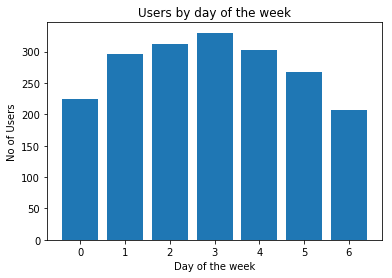

In [28]:
######  Bar chart for number of users by day of the week #######
x_axis=DailySession.index
plt.bar(x_axis,DailySession['user_id'])
plt.ylabel('No of Users')
plt.xlabel('Day of the week')
plt.title('Users by day of the week')
plt.show()

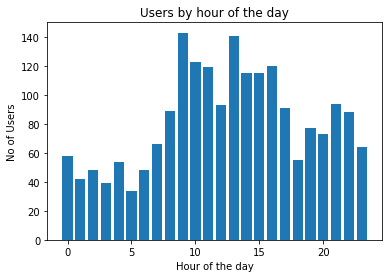

In [29]:
######  Bar chart for number of users by hours #######
### change the color ######
x_axis=HourSession.index
plt.bar(x_axis,HourSession['user_id'])
plt.ylabel('No of Users')
plt.xlabel('Hour of the day')
plt.title('Users by hour of the day')
plt.show()